# Code for Henry and Merlis SRM paper figures.

## Order : Main figures, SI figures and table 1 data at the end.

### Download additional data from http://www.meteo.mcgill.ca/~mhenry/files/CMIP5_data.tar.gz and http://www.meteo.mcgill.ca/~mhenry/files/iGCM_data.tar.gz and put the files in the same directory as this notebook

### Make sure matplotlib, numpy, climlab and netCDF4 are installed.Following function files need to be in the same directory : sigma_int.py, plot_meridional_E_transport.py, grae_w.m, integ_fr.m.

### Start with a few helper functions

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import ClimateUtils as clim
import climlab
from climlab import constants as const
from plot_meridional_E_transport import penergy_flux_vs_lat
import netCDF4
from netCDF4 import Dataset
from scipy import interpolate

# Calculate an area-weighted latitudinal mean
def mean_lat(lat,val):
    # assume lat in degrees
    w = np.cos(lat*np.pi/180)
    return np.sum(val*w)/np.sum(w)

# GCM data class
class ncdf_obj:
     def __init__(self,directory,file_ctl,file_pert):
        self.f_ctl = netCDF4.Dataset(directory + file_ctl + '/day_ave.nc')
        self.f_pert = netCDF4.Dataset(directory + file_pert + '/day_ave.nc')
        self.s_ctl = netCDF4.Dataset(directory + file_ctl + '/surf_ave.nc')
        self.s_pert = netCDF4.Dataset(directory + file_pert + '/surf_ave.nc')
        self.q_ctl = self.f_ctl.variables['shum_avg'][:]
        self.q_pert = self.f_pert.variables['shum_avg'][:]
        self.q_diff = self.q_pert - self.q_ctl
        self.rh_ctl = self.f_ctl.variables['rhum_avg'][:]
        self.rh_pert = self.f_pert.variables['rhum_avg'][:]
        self.lat_= self.f_ctl.variables['lat'][:]
        self.sig_= self.f_ctl.variables['sigma'][:]
        self.temp_ctl=self.f_ctl.variables['temp'][:]
        self.temp_pert=self.f_pert.variables['temp'][:]
        self.temp_diff = self.temp_pert - self.temp_ctl
        self.sat_ctl=np.mean(np.mean(self.s_ctl.variables['t_surf'][:],0),1)
        self.sat_pert=np.mean(np.mean(self.s_pert.variables['t_surf'][:],0),1)
        self.sat_diff = self.sat_pert - self.sat_ctl
        self.mse_flux_ctl=penergy_flux_vs_lat(directory + file_ctl + '/day_ave.nc')
        self.mse_flux_pert=penergy_flux_vs_lat(directory + file_pert + '/day_ave.nc')
        self.mse_flux_diff=self.mse_flux_pert-self.mse_flux_ctl

# function to get vertical structure of dataset poleward of lat_lev
# field_lin is the dataset, lat is the latitude field, lat_lev is the latitude bound
def plot_pole(field_lin, lat, lat_lev):
    lr_lin=np.zeros((field_lin).shape[0],)
    for i in range(field_lin.shape[0]):
        lr_lin[i]=mean_lat(lat[lat>lat_lev],field_lin[i,lat>lat_lev])
    return lr_lin

# class for climlab to impose external forcing
# written by Brian Rose following my github issue (https://github.com/brian-rose/climlab/issues/76)
class ExternalForcing(climlab.process.TimeDependentProcess):
    def __init__(self,**kwargs):
        super(ExternalForcing, self).__init__(**kwargs)
        self.forcing_tendencies = {}
        for var in self.state:
            self.forcing_tendencies[var] = 0. * self.state[var]

    def _compute(self):
        return self.forcing_tendencies

# if lat_bound not = 80, make sure to change insolation and albedo in single column models
lat_bound=80

# Collect GCM data into objects
co2 = ncdf_obj('iGCM_data/','300ppm','1200ppm')
solar = ncdf_obj('iGCM_data/','300ppm','300ppm_S1317')
srm = ncdf_obj('iGCM_data/','300ppm','1200ppm_S1317')

# Define a function that runs the polar atmospheric column
def run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transp_ctl=True, sh_ctl=True,
                   sw_surf_ctl=True, sw_atm_ctl=True):
    lat = lat_bound
    
    state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5.)
    model = climlab.TimeDependentProcess(state=state)
    
    dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_ctl.variables['dt_tg_advection'][:],0),2)
    dt_adv_ctl = plot_pole(dt_adv_ctl_,iGCM_run.lat_,lat)
    dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_pert.variables['dt_tg_advection'][:],0),2)
    dt_adv_inc = plot_pole(dt_adv_inc_,iGCM_run.lat_,lat)
    dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_ctl.variables['dt_tg_condensation'][:],0),2)
    dt_cond_ctl = plot_pole(dt_cond_ctl_,iGCM_run.lat_,lat)
    dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_pert.variables['dt_tg_condensation'][:],0),2)
    dt_cond_inc = plot_pole(dt_cond_inc_,iGCM_run.lat_,lat)

    dt_adv_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_ctl))
    z_adv = np.polyfit(model.lev,dt_adv_temp,4)
    dt_adv_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_adv_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_inc))
    z_adv_inc = np.polyfit(model.lev,dt_adv_inc,4)
    dt_adv_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    dt_cond_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_ctl))
    z_adv = np.polyfit(model.lev,dt_cond_temp,4)
    dt_cond_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_cond_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_inc))
    z_adv_inc = np.polyfit(model.lev,dt_cond_inc,4)
    dt_cond_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    if(sh_ctl==True):
        sh = np.interp(model.lev,iGCM_run.sig_*1000,plot_pole(iGCM_run.q_ctl,iGCM_run.lat_,lat))
    else:
        sh = np.interp(model.lev,iGCM_run.sig_*1000,plot_pole(iGCM_run.q_pert,iGCM_run.lat_,lat))
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=sh,
                                 insolation = insol,
                                 albedo = alb,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    if transp_ctl==True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit+dt_cond_fit
    else:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc+dt_cond_fit_inc
    shf = climlab.surface.SensibleHeatFlux(state=model.state, Cd=0.5E-3)
    lhf = climlab.surface.LatentHeatFlux(state=model.state, Cd=0.5E-3)
    lhf.q = sh
    model.add_subprocess('Radiation', rad)
    # model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('SHF', shf)
    model.add_subprocess('LHF', lhf)
    model.integrate_years(3,False)
    return model

### Collect CMIP5 data

In [2]:
outfile = np.load('./CMIP5_data/outfile_ts.npz')
lat_IPSL=outfile['lat_IPSL']
lat_CSIRO=outfile['lat_CSIRO']
lat_HadGEM=outfile['lat_HadGEM']
lat_HadGEM_int=(lat_HadGEM[1:] + lat_HadGEM[:-1]) / 2
lat_CCSM=outfile['lat_CCSM']
lat_CanESM=outfile['lat_CanESM']
plev_IPSL=outfile['plev_IPSL']
plev_CSIRO=outfile['plev_CSIRO']
plev_HadGEM=outfile['plev_HadGEM']
plev_CCSM=outfile['plev_CCSM']
plev_CanESM=outfile['plev_CanESM']
ts_pic_IPSL=outfile['ts_pic_IPSL']
ts_pic_CSIRO=outfile['ts_pic_CSIRO']
ts_pic_HadGEM=outfile['ts_pic_HadGEM']
ts_pic_CCSM=outfile['ts_pic_CCSM']
ts_pic_CanESM=outfile['ts_pic_CanESM']
ts_geo_IPSL=outfile['ts_geo_IPSL']
ts_geo_CSIRO=outfile['ts_geo_CSIRO']
ts_geo_HadGEM=outfile['ts_geo_HadGEM']
ts_geo_CCSM=outfile['ts_geo_CCSM']
ts_geo_CanESM=outfile['ts_geo_CanESM']
diff_IPSL = ts_geo_IPSL-ts_pic_IPSL
diff_CSIRO = ts_geo_CSIRO-ts_pic_CSIRO
diff_HadGEM = ts_geo_HadGEM-ts_pic_HadGEM
diff_CCSM = ts_geo_CCSM-ts_pic_CCSM
diff_CanESM = ts_geo_CanESM-ts_pic_CanESM
ta_pic_IPSL=np.loadtxt('./CMIP5_data/pic_IPSL.txt',delimiter=',')
ta_pic_CSIRO=np.loadtxt('./CMIP5_data/pic_CSIRO.txt',delimiter=',')
ta_pic_HadGEM=np.loadtxt('./CMIP5_data/pic_HadGEM.txt',delimiter=',')
ta_pic_CCSM=np.loadtxt('./CMIP5_data/pic_CCSM.txt',delimiter=',')
ta_pic_CanESM=np.loadtxt('./CMIP5_data/pic_CanESM.txt',delimiter=',')
ta_geo_IPSL=np.loadtxt('./CMIP5_data/geo_IPSL.txt',delimiter=',')
ta_geo_CSIRO=np.loadtxt('./CMIP5_data/geo_CSIRO.txt',delimiter=',')
ta_geo_HadGEM=np.loadtxt('./CMIP5_data/geo_HadGEM.txt',delimiter=',')
ta_geo_CCSM=np.loadtxt('./CMIP5_data/geo_CCSM.txt',delimiter=',')
ta_geo_CanESM=np.loadtxt('./CMIP5_data/geo_CanESM.txt',delimiter=',')

from scipy import interpolate
x = lat_HadGEM_int
y = plev_HadGEM
f = interpolate.interp2d(x, y[::-1], ta_geo_HadGEM[::-1,:]-ta_pic_HadGEM[::-1,:], kind='linear')
diff_HadGEM_interp = f(lat_IPSL, plev_IPSL[::-1])
diff_HadGEM_interp = diff_HadGEM_interp[::-1,:]

x = lat_CSIRO
y = plev_CSIRO
f = interpolate.interp2d(x, y[::-1], ta_geo_CSIRO[::-1,:]-ta_pic_CSIRO[::-1,:], kind='linear')
diff_CSIRO_interp = f(lat_IPSL, plev_IPSL[::-1])
diff_CSIRO_interp = diff_CSIRO_interp[::-1,:]

x = lat_CanESM
y = plev_CanESM
f = interpolate.interp2d(x, y[::-1], ta_geo_CanESM[::-1,:]-ta_pic_CanESM[::-1,:], kind='linear')
diff_CanESM_interp = f(lat_IPSL, plev_IPSL[::-1])
diff_CanESM_interp = diff_CanESM_interp[::-1,:]

x = lat_CCSM
y = plev_CCSM
f = interpolate.interp2d(x, y[::-1], ta_geo_CCSM[::-1,:]-ta_pic_CCSM[::-1,:], kind='linear')
diff_CCSM_interp = f(lat_IPSL, plev_IPSL[::-1])
diff_CCSM_interp = diff_CCSM_interp[::-1,:]

temp_min = -1.5
temp_max = 1.5

mean = (diff_CSIRO_interp+ta_geo_IPSL-ta_pic_IPSL+diff_HadGEM_interp+diff_CCSM_interp+diff_CanESM_interp)/5
std = np.sqrt(np.abs(ta_geo_IPSL-ta_pic_IPSL-mean)**2+np.abs(diff_HadGEM_interp-mean)**2+np.abs(diff_CCSM_interp-mean)**2+np.abs(diff_CSIRO_interp-mean)**2+np.abs(diff_CanESM_interp-mean)**2)
std_c = np.argwhere(std>1.5).T

### Main text figure 1

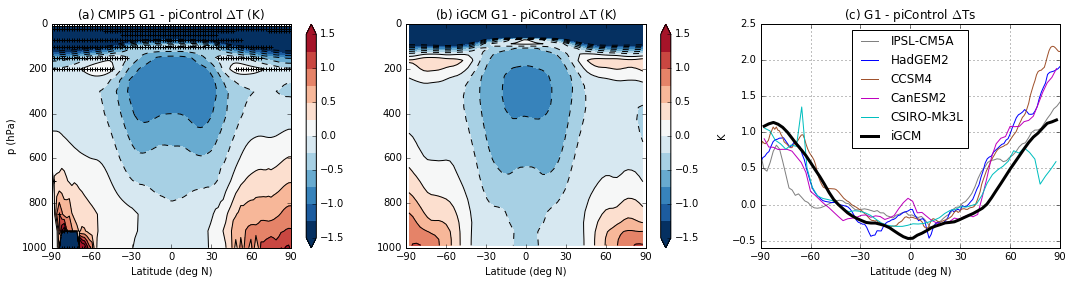

In [3]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 4)

plt.subplot(1,3,1)
lat, sig = np.meshgrid(lat_IPSL,plev_IPSL)
levels = np.linspace(temp_min,temp_max,13)
col = cm.RdBu(np.linspace(1, 0, len(levels)))
cs = plt.contourf(lat, sig, mean, levels, colors=col, extend="both")
plt.axis([lat.min(), lat.max(), sig.max(), sig.min()])
cb = plt.colorbar()
plt.contour(cs, colors='k')
plt.scatter(lat_IPSL[std_c[1,:]],plev_IPSL[std_c[0,:]],c='k', linewidth=1, marker='+')
plt.xticks(np.linspace(-90, 90, 7))
plt.yticks([0,200,400,600,800,1000])
plt.xlabel('Latitude (deg N)')
plt.ylabel('p (hPa)')
plt.title('(a) CMIP5 G1 - piControl $\Delta$T (K)')

plt.subplot(1,3,2)
lat, sig = np.meshgrid(srm.lat_,srm.sig_*1000)
levels = np.linspace(temp_min,temp_max,13)
col = cm.RdBu(np.linspace(1, 0, len(levels)))
cs = plt.contourf(lat, sig, srm.temp_diff, levels, colors=col, extend="both")
plt.axis([lat.min(), lat.max(), sig.max(), sig.min()])
cb = plt.colorbar()
plt.contour(cs, colors='k')
plt.yticks([0,200,400,600,800,1000])
plt.xticks(np.linspace(-90, 90, 7))
plt.xlabel('Latitude (deg N)')
# plt.ylabel('p (hPa)')
plt.xlim([-90,90])
plt.ylim([1000,0])
plt.title('(b) iGCM G1 - piControl $\Delta$T (K)')

plt.subplot(1,3,3)
plt.plot(lat_IPSL,diff_IPSL,'gray', label='IPSL-CM5A', linewidth=1)
plt.plot(lat_HadGEM,diff_HadGEM,'b', label='HadGEM2', linewidth=1)
plt.plot(lat_CCSM,diff_CCSM,'sienna', label='CCSM4', linewidth=1)
plt.plot(lat_CanESM,diff_CanESM,'m', label='CanESM2', linewidth=1)
plt.plot(lat_CSIRO,diff_CSIRO,'c', label='CSIRO-Mk3L', linewidth=1)
ts_mean = (diff_IPSL+np.interp(lat_IPSL,lat_HadGEM,diff_HadGEM)+ \
           np.interp(lat_IPSL,lat_CCSM,diff_CCSM)+ \
           np.interp(lat_IPSL,lat_CSIRO,diff_CSIRO)+ \
           np.interp(lat_IPSL,lat_CanESM,diff_CanESM))/5
# plt.plot(lat_IPSL,ts_mean,'k', label='mean', linewidth=3)
plt.plot(srm.lat_,srm.sat_diff,'k', label='iGCM', linewidth=3)
plt.grid()
plt.title('(c) G1 - piControl $\Delta$Ts')
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
plt.ylim([-0.6,2.5])
plt.legend(loc='best')
plt.ylabel('K')
plt.xlabel('Latitude (deg N)')
fig.tight_layout()
plt.savefig('fig1.eps')
plt.show()

### Run column models

In [4]:
model = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=175.2, alb=0.54, transp_ctl=True, sh_ctl=True)
model_co2 = run_pole_column(iGCM_run=srm, co2_lev=12e-4, insol=175.2, alb=0.54, transp_ctl=True, sh_ctl=True)
model_sol = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=169, alb=0.54, transp_ctl=True, sh_ctl=True)
model_ET = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=175.2, alb=0.54, transp_ctl=False, sh_ctl=True)
model_q = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=175.2, alb=0.54, transp_ctl=True, sh_ctl=False)
model_srm = run_pole_column(iGCM_run=srm, co2_lev=12e-4, insol=169, alb=0.54, transp_ctl=False, sh_ctl=False)

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


### Main text figure 2

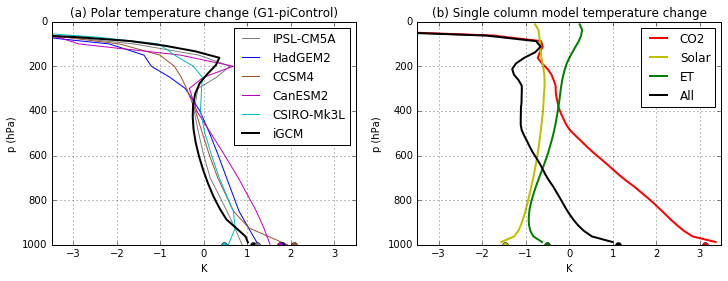

In [5]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(plot_pole(ta_geo_IPSL-ta_pic_IPSL, lat_IPSL, lat_bound),plev_IPSL,'gray', label='IPSL-CM5A', linewidth=1)
plt.plot(plot_pole(ta_geo_HadGEM-ta_pic_HadGEM, lat_HadGEM_int, lat_bound),plev_HadGEM,'b', label='HadGEM2', linewidth=1)
plt.plot(plot_pole(ta_geo_CCSM-ta_pic_CCSM, lat_CCSM, lat_bound),plev_CCSM,'sienna', label='CCSM4', linewidth=1)
plt.plot(plot_pole(ta_geo_CanESM-ta_pic_CanESM, lat_CanESM, lat_bound),plev_CanESM,'m', label='CanESM2', linewidth=1)
plt.plot(plot_pole(ta_geo_CSIRO-ta_pic_CSIRO, lat_CSIRO, lat_bound),plev_CSIRO,'c', label='CSIRO-Mk3L', linewidth=1)
plt.plot(plot_pole(srm.temp_diff,srm.lat_,lat_bound),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(srm.lat_[srm.lat_>lat_bound],srm.sat_diff[srm.lat_>lat_bound]), 1000, 'ko',markersize=6)
plt.plot(mean_lat(lat_IPSL[lat_IPSL>lat_bound],ts_geo_IPSL[lat_IPSL>lat_bound]-ts_pic_IPSL[lat_IPSL>lat_bound]), 1000, 'o', c='gray',markersize=6)
plt.plot(mean_lat(lat_HadGEM[lat_HadGEM>lat_bound],ts_geo_HadGEM[lat_HadGEM>lat_bound]-ts_pic_HadGEM[lat_HadGEM>lat_bound]), 1000, 'bo',markersize=6)
plt.plot(mean_lat(lat_CCSM[lat_CCSM>lat_bound],ts_geo_CCSM[lat_CCSM>lat_bound]-ts_pic_CCSM[lat_CCSM>lat_bound]), 1000, 'o', c='sienna',markersize=6)
plt.plot(mean_lat(lat_CanESM[lat_CanESM>lat_bound],ts_geo_CanESM[lat_CanESM>lat_bound]-ts_pic_CanESM[lat_CanESM>lat_bound]), 1000, 'mo',markersize=6)
plt.plot(mean_lat(lat_CSIRO[lat_CSIRO>lat_bound],ts_geo_CSIRO[lat_CSIRO>lat_bound]-ts_pic_CSIRO[lat_CSIRO>lat_bound]), 1000, 'co',markersize=6)
plt.title('(a) Polar temperature change (G1-piControl)')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-3.5,3.5])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(1,2,2)
plt.plot(model_co2.state['Tatm']-model.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_sol.state['Tatm']-model.state['Tatm'],model.lev,c='y',label='Solar',linewidth=2)
plt.plot(model_ET.state['Tatm']-model.state['Tatm'],model.lev,c='g',label='ET',linewidth=2)
plt.plot(model_srm.state['Tatm']-model.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(model_co2.state['Ts']-model.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(model_sol.state['Ts']-model.state['Ts'], 1000, 'yo',markersize=6)
plt.plot(model_ET.state['Ts']-model.state['Ts'], 1000, 'go',markersize=6)
plt.plot(model_srm.state['Ts']-model.state['Ts'], 1000, 'ko',markersize=6)
plt.title('(b) Single column model temperature change')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-3.5,3.5])
lgd =plt.legend(bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('fig2.eps')
plt.show()

### Run Cronin and Jansen's analytic radiative-advective model in matlab

In [2]:
import pymatlab
session = pymatlab.session_factory()
mscript = """p=linspace(1000,0,100);
[ T, Ts, olr , tau, I, F] =grae_w(p,3,1,30,150,1,2./7.,1,0);
[ T_fs, Ts_fs, olr_fs , tau_fs, I_fs, F_fs] =grae_w(p,3,1,27.3,150,1,2./7.,1,0);
[ T_co2, Ts_co2, olr_co2 , tau_co2, I_co2, F_co2] =grae_w(p,3.2,1,30,150,1,2./7.,1,0);
[ T_rad, Ts_rad, olr_rad , tau_rad, I_rad, F_rad] =grae_w(p,3,1,120,0,1,2./7.,1,0);
[ T_rad_co2, Ts_rad_co2, olr_rad_co2 , tau_rad_co2, I_rad_co2, F_rad_co2] =grae_w(p,3.2,1,120,0,1,2./7.,1,0);
[ T_rad_fs, Ts_rad_fs, olr_rad_fs , tau_rad_fs, I_rad_fs, F_rad_fs] =grae_w(p,3,1,116.4,0,1,2./7.,1,0);
forc_tau0_rad=integ_fr(Ts_rad, T_rad, 3.2, p)-olr_rad;
forc_tau0=integ_fr(Ts, T, 3.2, p)-olr;
"""
session.putvalue('MSCRIPT',mscript)
session.run('eval(MSCRIPT)')
p = session.getvalue('p')
T = session.getvalue('T')
T_fs = session.getvalue('T_fs')
T_co2 = session.getvalue('T_co2')
T_rad = session.getvalue('T_rad')
T_rad_co2 = session.getvalue('T_rad_co2')
T_rad_fs = session.getvalue('T_rad_fs')
Ts = session.getvalue('Ts')
Ts_fs = session.getvalue('Ts_fs')
Ts_co2 = session.getvalue('Ts_co2')
Ts_rad = session.getvalue('Ts_rad')
Ts_rad_co2 = session.getvalue('Ts_rad_co2')
Ts_rad_fs = session.getvalue('Ts_rad_fs')
olr = session.getvalue('olr')
olr_fs = session.getvalue('olr_fs')
olr_co2 = session.getvalue('olr_co2')
tau = session.getvalue('tau')
tau_fs = session.getvalue('tau_fs')
tau_co2 = session.getvalue('tau_co2')
I = session.getvalue('I')
I_fs = session.getvalue('I_fs')
I_co2 = session.getvalue('I_co2')
F = session.getvalue('F')
F_fs = session.getvalue('F_fs')
F_co2 = session.getvalue('F_co2')
forc_tau0 = session.getvalue('forc_tau0')
forc_tau0_rad = session.getvalue('forc_tau0_rad')

print(forc_tau0)
print(forc_tau0_rad)

-2.68336910811
-3.59745482108


### Main text figure 3

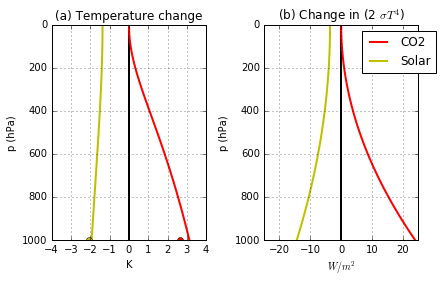

In [3]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)

plt.subplot(1,2,1)
plt.axvline(x=0,color='k',linewidth=2)
plt.plot(T_rad_co2-T_rad, p, 'r',linewidth=2,label='CO2')
plt.plot(T_rad_fs-T_rad, p, 'y',linewidth=2,label='Solar')
plt.plot(Ts_rad_fs-Ts_rad, 1000, 'yo',markersize=6)
plt.plot(Ts_rad_co2-Ts_rad, 1000, 'ro',markersize=6)
plt.gca().invert_yaxis()
plt.xlabel('K')
plt.xlim([-4,4])
plt.ylabel('p (hPa)')
plt.title('(a) Temperature change')
plt.grid()

plt.subplot(1,2,2)
plt.axvline(x=0,color='k',linewidth=2)
plt.plot(2*5.67e-8*T_rad_co2**4-2*5.67e-8*T_rad**4, p, 'r',linewidth=2,label='CO2')
plt.plot(2*5.67e-8*T_rad_fs**4-2*5.67e-8*T_rad**4, p, 'y',linewidth=2,label='Solar')
plt.gca().invert_yaxis()
lgd =plt.legend( bbox_to_anchor=(1.15, 1))
plt.xlabel('$W/m^2$')
plt.title('(b) Change in (2 $\sigma T^4$)')
plt.xlim([-25,25])
plt.ylabel('p (hPa)')
plt.grid()
fig.tight_layout()
plt.savefig('fig3.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Run single column models with lat_bound=60

In [8]:
lat_bound=60

# Define a function that runs the polar atmospheric column
def run_pole_column(iGCM_run=co2, co2_lev=3e-4, insol=175.2, alb=0.54, transp_ctl=True, sh_ctl=True,
                   sw_surf_ctl=True, sw_atm_ctl=True):
    lat = lat_bound
    
    state = climlab.column_state(num_lev=40, num_lat=1, water_depth=5.)
    model = climlab.TimeDependentProcess(state=state)
    
    dt_adv_ctl_ = np.mean(np.mean(iGCM_run.s_ctl.variables['dt_tg_advection'][:],0),2)
    dt_adv_ctl = plot_pole(dt_adv_ctl_,iGCM_run.lat_,lat)
    dt_adv_inc_ = np.mean(np.mean(iGCM_run.s_pert.variables['dt_tg_advection'][:],0),2)
    dt_adv_inc = plot_pole(dt_adv_inc_,iGCM_run.lat_,lat)
    dt_cond_ctl_ = np.mean(np.mean(iGCM_run.s_ctl.variables['dt_tg_condensation'][:],0),2)
    dt_cond_ctl = plot_pole(dt_cond_ctl_,iGCM_run.lat_,lat)
    dt_cond_inc_ = np.mean(np.mean(iGCM_run.s_pert.variables['dt_tg_condensation'][:],0),2)
    dt_cond_inc = plot_pole(dt_cond_inc_,iGCM_run.lat_,lat)

    dt_adv_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_ctl))
    z_adv = np.polyfit(model.lev,dt_adv_temp,4)
    dt_adv_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_adv_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_adv_inc))
    z_adv_inc = np.polyfit(model.lev,dt_adv_inc,4)
    dt_adv_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    dt_cond_temp = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_ctl))
    z_adv = np.polyfit(model.lev,dt_cond_temp,4)
    dt_cond_fit = model.lev**4*z_adv[0]+model.lev**3*z_adv[1]\
                +model.lev**2*z_adv[2]+model.lev*z_adv[3]+z_adv[4]
    dt_cond_inc = np.interp(model.lev,iGCM_run.sig_*1000,(dt_cond_inc))
    z_adv_inc = np.polyfit(model.lev,dt_cond_inc,4)
    dt_cond_fit_inc = model.lev**4*z_adv_inc[0]+model.lev**3*z_adv_inc[1]\
                +model.lev**2*z_adv_inc[2]+model.lev*z_adv_inc[3]+z_adv_inc[4]

    conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate='MALR')
    abs_vmr = climlab.radiation.radiation.default_absorbers(model.Tatm)
    abs_vmr['CO2']=co2_lev
    if(sh_ctl==True):
        sh = np.interp(model.lev,iGCM_run.sig_*1000,plot_pole(iGCM_run.q_ctl,iGCM_run.lat_,lat))
    else:
        sh = np.interp(model.lev,iGCM_run.sig_*1000,plot_pole(iGCM_run.q_pert,iGCM_run.lat_,lat))
    rad = climlab.radiation.RRTMG(state=state,
                                 specific_humidity=sh,
                                 insolation = insol,
                                 albedo = alb,
                                 absorber_vmr = abs_vmr)
    myforcing = ExternalForcing(state=state)
    if transp_ctl==True:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit+dt_cond_fit
    else:
        myforcing.forcing_tendencies['Tatm']=dt_adv_fit_inc+dt_cond_fit_inc
    shf = climlab.surface.SensibleHeatFlux(state=model.state, Cd=0.5E-3)
    lhf = climlab.surface.LatentHeatFlux(state=model.state, Cd=0.5E-3)
    lhf.q = sh
    model.add_subprocess('Radiation', rad)
    # model.add_subprocess('ConvectiveAdjustment', conv)
    model.add_subprocess('advective forcing', myforcing)
    model.add_subprocess('SHF', shf)
    model.add_subprocess('LHF', lhf)
    model.integrate_years(3,False)
    return model

SI_model = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=199, alb=0.47, transp_ctl=True, sh_ctl=True)
SI_model_co2 = run_pole_column(iGCM_run=srm, co2_lev=12e-4, insol=199, alb=0.47, transp_ctl=True, sh_ctl=True)
SI_model_sol = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=192, alb=0.47, transp_ctl=True, sh_ctl=True)
SI_model_ET = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=199, alb=0.47, transp_ctl=False, sh_ctl=True)
SI_model_q = run_pole_column(iGCM_run=srm, co2_lev=3e-4, insol=199, alb=0.47, transp_ctl=True, sh_ctl=False)
SI_model_srm = run_pole_column(iGCM_run=srm, co2_lev=12e-4, insol=192, alb=0.47, transp_ctl=False, sh_ctl=False)

lat_bound=80

Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Getting ozone data from /home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


### Supplementary figure 1

/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  app.launch_new_instance()
/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  app.launch_new_instance()
/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/home/mhenry/Programs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type


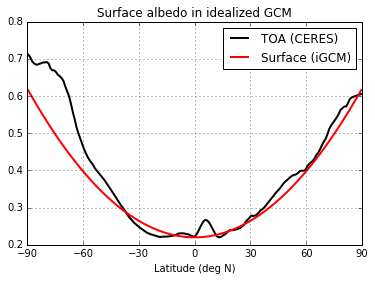

In [9]:
albedo_CERES_ = netCDF4.Dataset('./CERES_albedo.nc')
lat_ = albedo_CERES_.variables['lat'][:]
sol_ = np.mean(np.mean(albedo_CERES_.variables['solar_clim'][:],0),1)
toasw_ = np.mean(np.mean(albedo_CERES_.variables['toa_sw_all_clim'][:],0),1)
plt.plot(lat_,toasw_/sol_,'k',linewidth=2, label='TOA (CERES)')

CERES_albedo_poly = 0.22 + 0.4*(lat_/90)**2
plt.plot(lat_,CERES_albedo_poly,'r',linewidth=2, label='Surface (iGCM)')

plt.legend(loc='best')
plt.title('Surface albedo in idealized GCM')
plt.xlabel('Latitude (deg N)')
plt.xticks(np.linspace(-90, 90, 7))
plt.xlim([-90,90])
plt.legend(loc='best')
plt.grid()
# plt.savefig('figS1.eps')
plt.show()

### Supplementary figure 2

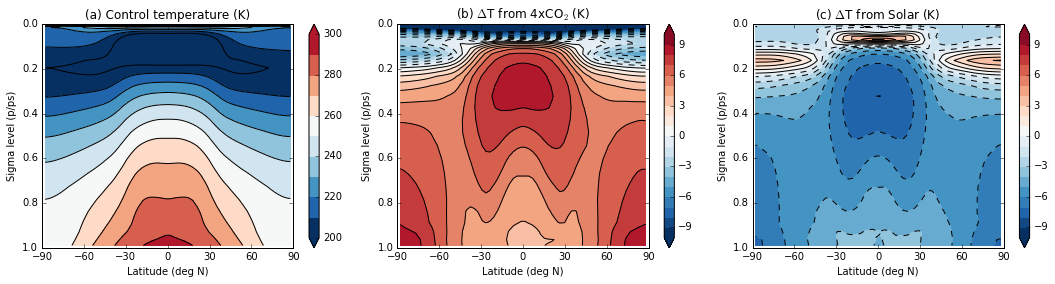

In [10]:
temp_min = 200
temp_max = 300
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15,4)
plt.subplot(1,3,1)
nonlin = ncdf_obj('iGCM_data/','300ppm','1200ppm_S1317')
lat, sig = np.meshgrid(nonlin.lat_,nonlin.sig_)
levels = np.linspace(temp_min,temp_max,11)
col = cm.RdBu(np.linspace(1, 0, len(levels)))
cs = plt.contourf(lat, sig, nonlin.temp_ctl, levels, colors=col, extend="both")
plt.axis([lat.min(), lat.max(), sig.max(), sig.min()])
cb = plt.colorbar()
plt.contour(cs, colors='k')
plt.yticks(np.linspace(1, 0, 6))
plt.xticks(np.linspace(-90, 90, 7))
plt.xlabel('Latitude (deg N)')
plt.ylabel('Sigma level (p/ps)')
plt.title('(a) Control temperature (K)')

temp_min = -10
temp_max = 10
plt.subplot(1,3,2)
nonlin = ncdf_obj('iGCM_data/','300ppm','1200ppm')
lat, sig = np.meshgrid(nonlin.lat_,nonlin.sig_)
levels = np.linspace(temp_min,temp_max,21)
col = cm.RdBu(np.linspace(1, 0, len(levels)))
cs = plt.contourf(lat, sig, nonlin.temp_diff, levels, colors=col, extend="both")
plt.axis([lat.min(), lat.max(), sig.max(), sig.min()])
cb = plt.colorbar()
plt.contour(cs, colors='k')
plt.yticks(np.linspace(1, 0, 6))
plt.xticks(np.linspace(-90, 90, 7))
plt.xlabel('Latitude (deg N)')
plt.ylabel('Sigma level (p/ps)')
plt.title('(b) $\Delta$T from 4xCO$_2$ (K)')

plt.subplot(1,3,3)
nonlin = ncdf_obj('iGCM_data/','300ppm','300ppm_S1317')
lat, sig = np.meshgrid(nonlin.lat_,nonlin.sig_)
levels = np.linspace(temp_min,temp_max,21)
col = cm.RdBu(np.linspace(1, 0, len(levels)))
cs = plt.contourf(lat, sig, nonlin.temp_diff, levels, colors=col, extend="both")
plt.axis([lat.min(), lat.max(), sig.max(), sig.min()])
cb = plt.colorbar()
plt.contour(cs, colors='k')
plt.yticks(np.linspace(1, 0, 6))
plt.xticks(np.linspace(-90, 90, 7))
plt.xlabel('Latitude (deg N)')
plt.ylabel('Sigma level (p/ps)')
plt.title('(c) $\Delta$T from Solar (K)')
fig.tight_layout()
plt.savefig('figS2.eps')
plt.show()

### Supplementary figure 3

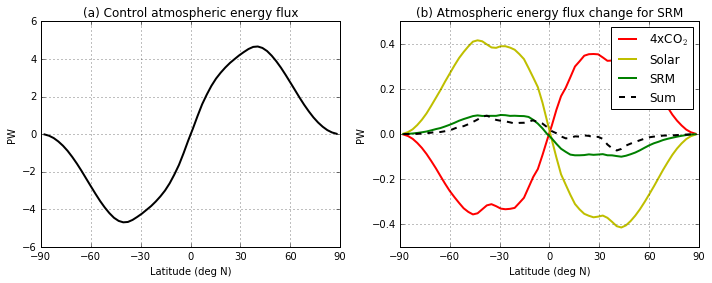

In [11]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 4)
plt.subplot(1,2,1)
nonlin = ncdf_obj('iGCM_data/','300ppm','1200ppm')
plt.plot(nonlin.lat_,nonlin.mse_flux_ctl,'k', linewidth=2)
plt.title('(a) Control atmospheric energy flux')
plt.xlabel('Latitude (deg N)')
plt.xticks(np.linspace(-90, 90, 7))
plt.ylim(-6,6)
plt.xlim([-90,90])
plt.ylabel('PW')
plt.grid()

plt.subplot(1,2,2)
nonlin = ncdf_obj('iGCM_data/','300ppm','1200ppm')
plt.plot(nonlin.lat_,nonlin.mse_flux_diff,'r', label='4xCO$_2$', linewidth=2)
nonlin = ncdf_obj('iGCM_data/','300ppm','300ppm_S1317')
plt.plot(nonlin.lat_,nonlin.mse_flux_diff,'y', label='Solar', linewidth=2)
nonlin = ncdf_obj('iGCM_data/','300ppm','1200ppm_S1317')
plt.plot(nonlin.lat_,nonlin.mse_flux_diff,'g',label='SRM', linewidth=2)
solar = ncdf_obj('iGCM_data/','300ppm','300ppm_S1317')
co2 = ncdf_obj('iGCM_data/','300ppm','1200ppm')
plt.plot(nonlin.lat_,(co2.mse_flux_diff)+(solar.mse_flux_diff),'k--',label='Sum', linewidth=2)
plt.title('(b) Atmospheric energy flux change for SRM')
plt.xlabel('Latitude (deg N)')
plt.xticks(np.linspace(-90, 90, 7))
plt.ylim(-0.5,0.5)
plt.xlim([-90,90])
plt.ylabel('PW')
plt.legend(loc='best')
plt.grid()
fig.tight_layout()
plt.savefig('figS3.eps')
plt.show()

### Supplementary figure 4

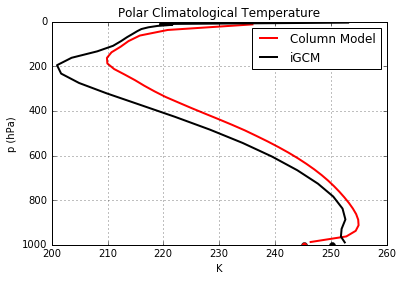

In [12]:
plt.plot(model.state['Tatm'],model.lev,c='r',label='Column Model',linewidth=2)
plt.plot(model.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(plot_pole(co2.temp_ctl,co2.lat_,lat_bound),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(co2.lat_[co2.lat_>lat_bound],co2.sat_ctl[co2.lat_>lat_bound]), 1000, 'ko',markersize=6)
plt.title('Polar Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS4.eps')
plt.show()

### Supplementary figure 5

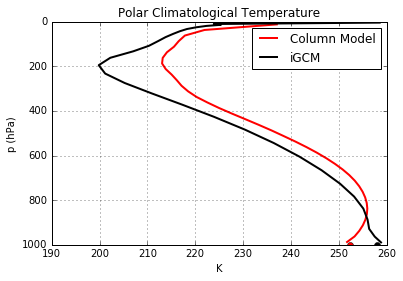

In [13]:
plt.plot(SI_model.state['Tatm'],model.lev,c='r',label='Column Model',linewidth=2)
plt.plot(SI_model.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(plot_pole(co2.temp_ctl,co2.lat_,60),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(co2.lat_[co2.lat_>60],co2.sat_ctl[co2.lat_>60]), 1000, 'ko',markersize=6)
plt.title('Polar Climatological Temperature')
plt.xlabel('K')
plt.ylabel('p (hPa)')
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS5.eps')
plt.show()

### Supplementary figure 6

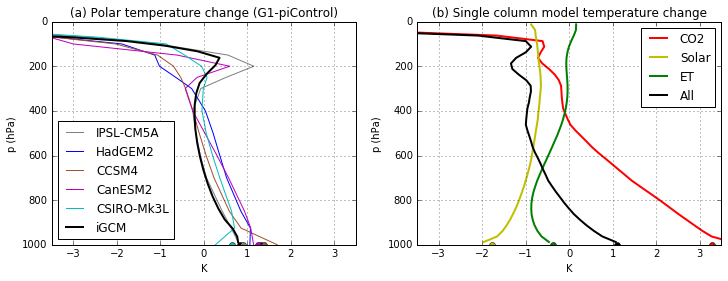

In [14]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 4)
plt.subplot(1,2,1)
plt.plot(plot_pole(ta_geo_IPSL-ta_pic_IPSL, lat_IPSL, 60),plev_IPSL,'gray', label='IPSL-CM5A', linewidth=1)
plt.plot(plot_pole(ta_geo_HadGEM-ta_pic_HadGEM, lat_HadGEM_int, 60),plev_HadGEM,'b', label='HadGEM2', linewidth=1)
plt.plot(plot_pole(ta_geo_CCSM-ta_pic_CCSM, lat_CCSM, 60),plev_CCSM,'sienna', label='CCSM4', linewidth=1)
plt.plot(plot_pole(ta_geo_CanESM-ta_pic_CanESM, lat_CanESM, 60),plev_CanESM,'m', label='CanESM2', linewidth=1)
plt.plot(plot_pole(ta_geo_CSIRO-ta_pic_CSIRO, lat_CSIRO, 60),plev_CSIRO,'c', label='CSIRO-Mk3L', linewidth=1)
plt.plot(plot_pole(srm.temp_diff,srm.lat_,60),co2.sig_*1000, 'k', label='iGCM',linewidth=2)
plt.plot(mean_lat(srm.lat_[srm.lat_>60],srm.sat_diff[srm.lat_>60]), 1000, 'ko',markersize=6)
plt.plot(mean_lat(lat_IPSL[lat_IPSL>60],ts_geo_IPSL[lat_IPSL>60]-ts_pic_IPSL[lat_IPSL>60]), 1000, 'o', c='gray',markersize=6)
plt.plot(mean_lat(lat_HadGEM[lat_HadGEM>60],ts_geo_HadGEM[lat_HadGEM>60]-ts_pic_HadGEM[lat_HadGEM>60]), 1000, 'bo',markersize=6)
plt.plot(mean_lat(lat_CCSM[lat_CCSM>60],ts_geo_CCSM[lat_CCSM>60]-ts_pic_CCSM[lat_CCSM>60]), 1000, 'o', c='sienna',markersize=6)
plt.plot(mean_lat(lat_CanESM[lat_CanESM>60],ts_geo_CanESM[lat_CanESM>60]-ts_pic_CanESM[lat_CanESM>60]), 1000, 'mo',markersize=6)
plt.plot(mean_lat(lat_CSIRO[lat_CSIRO>60],ts_geo_CSIRO[lat_CSIRO>60]-ts_pic_CSIRO[lat_CSIRO>60]), 1000, 'co',markersize=6)
plt.title('(a) Polar temperature change (G1-piControl)')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-3.5,3.5])
lgd =plt.legend(loc='best')
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(1,2,2)
plt.plot(SI_model_co2.state['Tatm']-SI_model.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(SI_model_sol.state['Tatm']-SI_model.state['Tatm'],model.lev,c='y',label='Solar',linewidth=2)
plt.plot(SI_model_ET.state['Tatm']-SI_model.state['Tatm'],model.lev,c='g',label='ET',linewidth=2)
plt.plot(SI_model_srm.state['Tatm']-SI_model.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(SI_model_co2.state['Ts']-SI_model.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(SI_model_sol.state['Ts']-SI_model.state['Ts'], 1000, 'yo',markersize=6)
plt.plot(SI_model_ET.state['Ts']-SI_model.state['Ts'], 1000, 'go',markersize=6)
plt.plot(SI_model_srm.state['Ts']-SI_model.state['Ts'], 1000, 'ko',markersize=6)
plt.title('(b) Single column model temperature change')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-3.5,3.5])
lgd =plt.legend(bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS6.eps')
plt.show()

### Supplementary figure 7

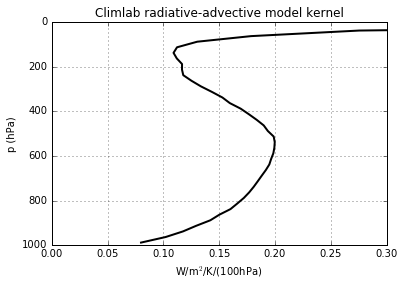

[ 1.31825594]


In [15]:
rce_kernel = climlab.process_like(model)
rce_kernel.state['Ts']+=1
rce_kernel.compute_diagnostics()
kernel_s = rce_kernel.OLR-model.OLR

kernel_atm = np.zeros_like(model.state['Tatm'])
for i in range(len(model.state['Tatm'])):
    rce_kernel = climlab.process_like(model)
    rce_kernel.state['Tatm'][i]+=1
    rce_kernel.compute_diagnostics()
    kernel_atm[i] = rce_kernel.OLR-model.OLR
    
plt.plot(100/np.diff(model.lev_bounds)*kernel_atm,model.lev,'k',linewidth=2)
plt.title('Climlab radiative-advective model kernel')
plt.xlabel('W/m$^2$/K/(100hPa)')
plt.ylabel('p (hPa)')
plt.xlim([0,0.3])
plt.ylim([0,1000])
# plt.legend()
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS7.eps')
plt.show()

print(kernel_s)

### Supplementary figure 8

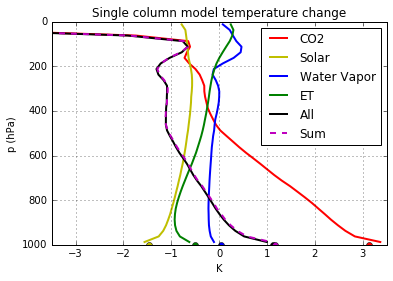

In [16]:
plt.plot(model_co2.state['Tatm']-model.state['Tatm'],model.lev,c='r',label='CO2',linewidth=2)
plt.plot(model_sol.state['Tatm']-model.state['Tatm'],model.lev,c='y',label='Solar',linewidth=2)
plt.plot(model_q.state['Tatm']-model.state['Tatm'],model.lev,c='b',label='Water Vapor',linewidth=2)
plt.plot(model_ET.state['Tatm']-model.state['Tatm'],model.lev,c='g',label='ET',linewidth=2)
plt.plot(model_srm.state['Tatm']-model.state['Tatm'],model.lev,c='k',label='All',linewidth=2)
plt.plot(model_co2.state['Tatm']+model_sol.state['Tatm']+model_q.state['Tatm']+model_ET.state['Tatm']
         -4*model.state['Tatm'],model.lev,'m--',label='Sum',linewidth=2)
plt.plot(model_co2.state['Ts']-model.state['Ts'], 1000, 'ro',markersize=6)
plt.plot(model_sol.state['Ts']-model.state['Ts'], 1000, 'yo',markersize=6)
plt.plot(model_q.state['Ts']-model.state['Ts'], 1000, 'bo',markersize=6)
plt.plot(model_ET.state['Ts']-model.state['Ts'], 1000, 'go',markersize=6)
plt.plot(model_srm.state['Ts']-model.state['Ts'], 1000, 'ko',markersize=6)
plt.plot(model_co2.state['Ts']+model_sol.state['Ts']+model_q.state['Ts']+model_ET.state['Ts']
         -4*model.state['Ts'], 1000, 'mo',markersize=6)
plt.title('Single column model temperature change')
plt.xlabel('K')
plt.ylabel('p (hPa)')
plt.xlim([-3.5,3.5])
lgd =plt.legend(bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()
plt.grid()
plt.savefig('figS8.eps')
plt.show()

### Supplementary figure 9

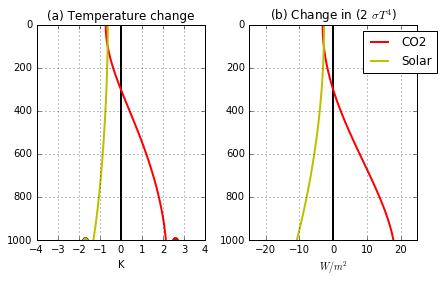

In [17]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)

plt.subplot(1,2,1)
plt.axvline(x=0,color='k',linewidth=2)
plt.plot(T_co2-T, p, 'r',linewidth=2,label='CO2')
plt.plot(T_fs-T, p, 'y',linewidth=2,label='Solar')
plt.plot(Ts_fs-Ts, 1000, 'yo',markersize=6)
plt.plot(Ts_co2-Ts, 1000, 'ro',markersize=6)
plt.gca().invert_yaxis()
plt.xlabel('K')
plt.xlim([-4,4])
plt.title('(a) Temperature change')
plt.grid()

plt.subplot(1,2,2)
plt.axvline(x=0,color='k',linewidth=2)
plt.plot(2*5.67e-8*T_co2**4-2*5.67e-8*T**4, p, 'r',linewidth=2,label='CO2')
plt.plot(2*5.67e-8*T_fs**4-2*5.67e-8*T**4, p, 'y',linewidth=2,label='Solar')
plt.gca().invert_yaxis()
lgd =plt.legend( bbox_to_anchor=(1.15, 1))
plt.xlabel('$W/m^2$')
plt.title('(b) Change in (2 $\sigma T^4$)')
plt.xlim([-25,25])
plt.grid()
fig.tight_layout()
plt.savefig('figS9.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Supplementary figure 10

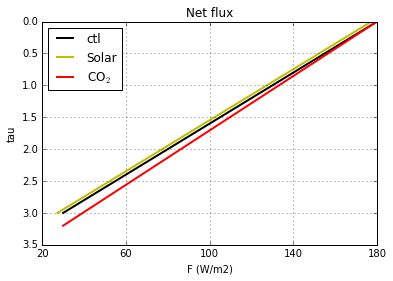

In [18]:
plt.plot(F,tau, 'k',linewidth=2,label='ctl')
plt.plot(F_fs,tau, 'y',linewidth=2,label='Solar')
plt.plot(F_co2,tau_co2, 'r',linewidth=2,label='CO$_2$')
plt.gca().invert_yaxis()
plt.xticks(np.linspace(20,180,5))
lgd =plt.legend(loc='best')
plt.xlabel('F (W/m2)')
plt.ylabel('tau')
plt.title('Net flux')
plt.grid()
plt.savefig('figS10.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Data for Table 1

In [19]:
sep=8
print('Planck feedback : ',kernel_s+sum(kernel_atm[sep:len(kernel_atm)]))

sep=8
strat_cont = np.sum(kernel_atm[0:sep]*(model_co2.state['Tatm'][0:sep]-model.state['Tatm'][0:sep]))
trop_cont = np.sum(kernel_atm[sep:len(kernel_atm)]*(model_co2.state['Tatm'][sep:len(kernel_atm)]-model.state['Tatm'][sep:len(kernel_atm)]))
surf_cont = kernel_s*(model_co2.state['Ts']-model.state['Ts'])
print('co2 , forcing : ', trop_cont+surf_cont)
print('co2, dTs : ', (model_co2.state['Ts']-model.state['Ts']))
print('co2, temp fb = -dOLR/dTs : ', -(trop_cont+surf_cont)/(model_co2.state['Ts']-model.state['Ts']))
print('co2, LR fb = -dOLR/dTs-planck : ', -(trop_cont+surf_cont)/(model_co2.state['Ts']-model.state['Ts']) - (-2.44))

strat_cont = np.sum(kernel_atm[0:sep]*(model_sol.state['Tatm'][0:sep]-model.state['Tatm'][0:sep]))
trop_cont = np.sum(kernel_atm[sep:len(kernel_atm)]*(model_sol.state['Tatm'][sep:len(kernel_atm)]-model.state['Tatm'][sep:len(kernel_atm)]))
surf_cont = kernel_s*(model_sol.state['Ts']-model.state['Ts'])
print('sol , forcing : ', trop_cont+surf_cont)
print('sol, dTs : ', (model_sol.state['Ts']-model.state['Ts']))
print('sol, temp fb : ', -(trop_cont+surf_cont)/(model_sol.state['Ts']-model.state['Ts']))
print('sol, LR fb : ', -(trop_cont+surf_cont)/(model_sol.state['Ts']-model.state['Ts']) + 2.44)

strat_cont = np.sum(kernel_atm[0:sep]*(model_ET.state['Tatm'][0:sep]-model.state['Tatm'][0:sep]))
trop_cont = np.sum(kernel_atm[sep:len(kernel_atm)]*(model_ET.state['Tatm'][sep:len(kernel_atm)]-model.state['Tatm'][sep:len(kernel_atm)]))
surf_cont = kernel_s*(model_ET.state['Ts']-model.state['Ts'])
print('ET, forcing : ', trop_cont+surf_cont)
print('ET, dTs : ', (model_ET.state['Ts']-model.state['Ts']))
print('ET, temp fb : ', -(trop_cont+surf_cont)/(model_ET.state['Ts']-model.state['Ts']))
print('ET, LR fb : ', -(trop_cont+surf_cont)/(model_ET.state['Ts']-model.state['Ts']) + 2.44)

strat_cont = np.sum(kernel_atm[0:sep]*(model_srm.state['Tatm'][0:sep]-model.state['Tatm'][0:sep]))
trop_cont = np.sum(kernel_atm[sep:len(kernel_atm)]*(model_srm.state['Tatm'][sep:len(kernel_atm)]-model.state['Tatm'][sep:len(kernel_atm)]))
surf_cont = kernel_s*(model_srm.state['Ts']-model.state['Ts'])
print('srm , forcing : ', trop_cont+surf_cont)
print('srm, dTs : ', (model_srm.state['Ts']-model.state['Ts']))
print('srm, temp fb : ', -(trop_cont+surf_cont)/(model_srm.state['Ts']-model.state['Ts']))
print('srm, WV fb : ', (model_q.OLR-model.OLR)/(model_srm.state['Ts']-model.state['Ts']))
print('srm, LR fb : ', -(trop_cont+surf_cont)/(model_srm.state['Ts']-model.state['Ts']) + 2.44)

strat_cont = np.sum(kernel_atm[0:sep]*np.interp(model.lev,srm.sig_*1000,(plot_pole(srm.temp_diff,srm.lat_,lat_bound)))[0:sep])
trop_cont = np.sum(kernel_atm[sep:len(kernel_atm)]*np.interp(model.lev,srm.sig_*1000,(plot_pole(srm.temp_diff,srm.lat_,lat_bound)))[sep:len(kernel_atm)])
surf_cont = kernel_s*(mean_lat(srm.lat_[srm.lat_>lat_bound],srm.sat_diff[srm.lat_>lat_bound]))
print('srm iGCM (using kernel) , forcing : ', trop_cont+surf_cont)
print('srm iGCM (using kernel), dTs : ', (mean_lat(srm.lat_[srm.lat_>lat_bound],srm.sat_diff[srm.lat_>lat_bound])))
print('srm iGCM (using kernel), temp fb : ', -(trop_cont+surf_cont)/mean_lat(srm.lat_[srm.lat_>lat_bound],
                            srm.sat_diff[srm.lat_>lat_bound]))
print('srm iGCM (using kernel), LR fb : ', -(trop_cont+surf_cont)/(mean_lat(srm.lat_[srm.lat_>lat_bound],srm.sat_diff[srm.lat_>lat_bound])) + 2.44)

('Planck feedback : ', Field([ 2.61691379]))
('co2 , forcing : ', Field([ 5.16876083]))
('co2, dTs : ', Field([ 3.12476748]))
('co2, temp fb = -dOLR/dTs : ', Field([-1.65412654]))
('co2, LR fb = -dOLR/dTs-planck : ', Field([ 0.78587346]))
('sol , forcing : ', Field([-2.95667323]))
('sol, dTs : ', Field([-1.47368383]))
('sol, temp fb : ', Field([-2.00631449]))
('sol, LR fb : ', Field([ 0.43368551]))
('ET, forcing : ', Field([-1.35185994]))
('ET, dTs : ', Field([-0.51014908]))
('ET, temp fb : ', Field([-2.64993115]))
('ET, LR fb : ', Field([-0.20993115]))
('srm , forcing : ', Field([ 0.6259619]))
('srm, dTs : ', Field([ 1.12032081]))
('srm, temp fb : ', Field([-0.55873452]))
('srm, WV fb : ', Field([ 0.08514426]))
('srm, LR fb : ', Field([ 1.88126548]))
('srm iGCM (using kernel) , forcing : ', Field([ 1.5606222]))
('srm iGCM (using kernel), dTs : ', 1.1395371637245366)
('srm iGCM (using kernel), temp fb : ', Field([-1.36952286]))
('srm iGCM (using kernel), LR fb : ', Field([ 1.07047714])